# HW 5 - Page Rank
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In Weeks 8 and 9 you discussed key concepts related to graph based algorithms and implemented SSSP.   
In this final homework assignment you'll implement distributed PageRank using some data from Wikipedia.
By the end of this homework you should be able to:  
* ... __compare/contrast__ adjacency matrices and lists as representations of graphs for parallel computation.
* ... __explain__ the goal of the PageRank algorithm using the concept of an infinite Random Walk.
* ... __define__ a Markov chain including the conditions underwhich it will converge.
* ... __identify__ what modifications must be made to the web graph inorder to leverage Markov Chains.
* ... __implement__ distributed PageRank in Spark.

__Please refer to the `README` for homework submission instructions and additional resources.__ 

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw5_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

__`REMINDER`__: If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Question 1: Distributed Graph Processing
Chapter 5 from Lin & Dyer gave you a high level introduction to graph algorithms and concernts that come up when trying to perform distributed computations over them. The questions below are designed to make sure you captured the key points from this reading and your async lectures. 

### Q1 Tasks:

* __a) short response:__ Give an example of a dataset that would be appropriate to represent as a graph. What are the nodes/edges in this dataset? Is the graph you describe 'directed' or 'undirected'? What would the average "in-degree" of a node mean in the context of your example? 

* __b) short response:__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm?

* __c) short response:__ Briefly describe Dijskra's algorithm (goal/approach). What specific design component makes this approach hard to parallelize?

* __d) short response:__ How does parallel breadth-first-search get around the problem that you identified in part `c`? At what expense?

### Q1 Student Answers:
> __a)__ An example can be a dataset of different places and distances between each. The nodes are the places and the edges are the paths between the places. This graph would be undirected since the path can travel both directions. The in-degree of a node in this context means the different paths that lead to the place (node)

> __b)__ Algorithms that traverse the graph needs to have access to the full structure of the graph and it's hard to parallelize

> __c)__ Dijskstra's algorithm is a greedy algorithm that traverse the graph in a breadth-first manner and use a priority queue to record which nodes are being expanded. The priority queue can then prioritize the nodes with small distances to leave and become visited, while the nodes with long distance can be updated if the future in a shorter path is found.  The priority queue is very hard to parallelize since a reducer is needed everytime to compute the distance of all nodes in queue. 

> __d)__ The BFS algorithm gets around the priority queue design by revisiting the "visited nodes" and if a shorted path is found, it recomputes the shortest path for each node in the subgraph emanating from that node. This is at the expense of a higher time complexity


# Question 2: Representing Graphs 

In class you saw examples of adjacency matrix and adjacency list representations of graphs. These data structures were probably familiar from HW3, though we hadn't before talked about them in the context of graphs. In this question we'll discuss some of the tradeoffs associated with these representations. __`NOTE:`__ We'll use the graph from Figure 5.1 in Lin & Dyer as a toy example. For convenience in the code below we'll label the nodes `A`, `B`, `C`, `D`, and `E` instead of $n_1$, $n_2$, etc but otherwise you should be able to follow along & check our answers against those in the text.

### Q2 Tasks:

* __a) short response:__ Relatively speaking, is the graph you described in `part a` "sparse" or "dense"?  Explain how sparsity/density impacts the adjacency matrix and adjacency list representations of a graph.

* __b) short response:__ Run the provided code to create and plot our toy graph. Is this graph directed or undirected? Explain how the adjacency matrices for directed graphs will differ from those of undirected graphs.

* __c) code:__ Fill in the missing code to complete the function `get_adj_matr()`.

* __d) code:__ Fill in the missing code to complete the function `get_adj_list()`.


### Q2 Student Answers:
> __a)__ It's sparse since most places will be be only connected to a handful of other places. For a highly dense graph, the space complexity of the adjency matrix might be better since it's one-hot encoded and only half need to used for undirected graph. However, for a sparce graph like part a, using adjacency lists greatly reduces the space complexity since most entries in the matrix will be 0 yet sill occupy memory.

> __b)__ It is directed; the adjacency matrices for undirected graphs are symmetrical along the diagonal line and only half needs to be used. But those for directed graphs would not be so. 



In [6]:
# part a - a graph is just a list of nodes and edges (RUN THIS CELL AS IS)
TOY_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
             'edges':[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), 
                      ('D', 'E'), ('E', 'A'),('E', 'B'), ('E', 'C')]}

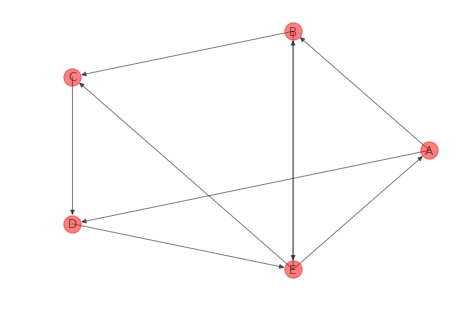

In [7]:
# part a - simple visualization of our toy graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY_GRAPH['nodes'])
G.add_edges_from(TOY_GRAPH['edges'])
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5)

In [8]:
# part c - adjacency matrix function
def get_adj_matr(graph):
    """
    Function to create an adjacency matrix representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        pd.DataFrame with entry i,j representing an edge from node i to node j
    """
    n = len(graph['nodes'])
    adj_matr = pd.DataFrame(0, columns = graph['nodes'], index = graph['nodes'])
    ############### YOUR CODE HERE ##################
    for s, e in graph['edges']:
        adj_matr.loc[s][e] = 1
        
    ############### (END) YOUR CODE #################
    return adj_matr

In [9]:
# part c - take a look (RUN THIS CELL AS IS)
TOY_ADJ_MATR = get_adj_matr(TOY_GRAPH)
print(TOY_ADJ_MATR)

   A  B  C  D  E
A  0  1  0  1  0
B  0  0  1  0  1
C  0  0  0  1  0
D  0  0  0  0  1
E  1  1  1  0  0


In [10]:
# part d - adjacency list function
def get_adj_list(graph):
    """
    Function to create an adjacency list representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        dictionary of the form {node : [list of edges]}
    """
    adj_list = {node: [] for node in graph['nodes']}
    ############### YOUR CODE HERE ##################
    for s, e in graph['edges']:
        adj_list[s].append(e)
    ############### (END) YOUR CODE #################
    return adj_list

In [11]:
# part d - take a look (RUN THIS CELL AS IS)
TOY_ADJ_LIST = get_adj_list(TOY_GRAPH)
print(TOY_ADJ_LIST)

{'A': ['B', 'D'], 'B': ['C', 'E'], 'C': ['D'], 'D': ['E'], 'E': ['A', 'B', 'C']}


# Question 3: Markov Chains and Random Walks

As you know from your readings and in class discussions, the PageRank algorithm takes advantage of the machinery of Markov Chains to compute the relative importance of a webpage using the hyperlink structure of the web (we'll refer to this as the 'web-graph'). A Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value which is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. In this question we'll briefly discuss a few concepts that are key to understanding the math behind PageRank. 

### Q2 Tasks:

* __a) short response:__ It is common to explain PageRank using the analogy of a web surfer who clicks on links at random ad infinitum. In the context of this hypothetical infinite random walk, what does the PageRank metric measure/represent?

* __b) short response:__ What is the "Markov Property" and what does it mean in the context of PageRank?

* __c) short response:__ A Markov chain consists of $n$ states plus an $n\times n$ transition probability matrix. In the context of PageRank & a random walk over the WebGraph what are the $n$ states? what implications does this have about the size of the transition matrix?

* __d) code + short response:__ What is a "right stochastic matrix"? Fill in the code below to compute the transition matrix for the toy graph from question 2. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]

* __e) code + short response:__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. Your code should print the results of each iteration. How many iterations does it take to converge? Which node is most 'central' (i.e. highest ranked)? Does this match your intuition? 
    * __`NOTE 1:`__ _this is a naive approach, well unpack what it means to be "nice" in the next question_.
    * __`NOTE 2:`__ _no need to implement a stopping criteria, visual inspection should suffice_.

### Q3 Student Answers:
> __a)__ In such scenario, the PageRank measures the visit rate of different link over an extended period of time

> __b)__ The markov property is that the random process is memoryless - the next state depends only on the current state but not the sequence of events that preceded it. In the context of PageRank, it means that the probability of the visit to the next page only depends on the web page the surfer is on currently.

> __c)__ The n states in the WebGraph are the different websites. That means that there are approximately 200 billion states in the PageRank 

> __d)__ A right stochastic metrix is a real square matrics with each row summing to 1.

> __e)__ It took around 50 iterations to converge. Node E is most central and it matches my intuition since it's the only node that has paths to three nodes

In [12]:
# part d - recall what the adjacency matrix looked like (RUN THIS CELL AS IS)
TOY_ADJ_MATR

,A,B,C,D,E
A,0,1,0,1,0
B,0,0,1,0,1
C,0,0,0,1,0
D,0,0,0,0,1
E,1,1,1,0,0


In [21]:
# part d - use TOY_ADJ_MATR to create a right stochastic transition matrix for this graph
################ YOUR CODE HERE #################
transition_matrix = TOY_ADJ_MATR.div(TOY_ADJ_MATR.sum(axis = 1), axis = 0)
################ (END) YOUR CODE #################
print(transition_matrix)

          A         B         C    D    E
A  0.000000  0.500000  0.000000  0.5  0.0
B  0.000000  0.000000  0.500000  0.0  0.5
C  0.000000  0.000000  0.000000  1.0  0.0
D  0.000000  0.000000  0.000000  0.0  1.0
E  0.333333  0.333333  0.333333  0.0  0.0


In [31]:
# part e - compute the steady state using the transition matrix 
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """
    Function to perform the specified number of power iteration steps to 
    compute the steady state probability distribution for the given
    transition matrix.
    
    Args:
        xInit     - (n x 1 array) representing inial state
        tMatrix  - (n x n array) transition probabilities
        nIter     - (int) number of iterations
    Returns:
        state_vector - (n x 1 array) representing probability 
                        distribution over states after nSteps.
    
    NOTE: if the 'verbose' flag is on, your function should print the step
    number and the current matrix at each iteration.
    """
    state_vector = None
    ################ YOUR CODE HERE #################
    
    for i in range(0, nIter):
        xInit = np.matmul(xInit, tMatrix)
        if verbose:
            print('Step', i+1, xInit)
    
    state_vector = xInit
    ################ (END) YOUR CODE #################
    return state_vector

In [37]:
# part e - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 60, verbose = True)

Step 1 [0.  0.5 0.  0.5 0. ]
Step 2 [0.   0.   0.25 0.   0.75]
Step 3 [0.25 0.25 0.25 0.25 0.  ]
Step 4 [0.    0.125 0.125 0.375 0.375]
Step 5 [0.125  0.125  0.1875 0.125  0.4375]
Step 6 [0.14583333 0.20833333 0.20833333 0.25       0.1875    ]
Step 7 [0.0625     0.13541667 0.16666667 0.28125    0.35416667]
Step 8 [0.11805556 0.14930556 0.18576389 0.19791667 0.34895833]
Step 9 [0.11631944 0.17534722 0.19097222 0.24479167 0.27256944]
Step 10 [0.09085648 0.1490162  0.17853009 0.24913194 0.33246528]
Step 11 [0.11082176 0.15625    0.18532986 0.22395833 0.32364005]
Step 12 [0.10788002 0.1632909  0.18600502 0.24074074 0.30208333]
Step 13 [0.10069444 0.15463445 0.18233989 0.23994502 0.32238619]
Step 14 [0.10746206 0.15780928 0.18477929 0.23268711 0.31726225]
Step 15 [0.10575408 0.15948511 0.18465873 0.23851032 0.31159176]
Step 16 [0.10386392 0.15674096 0.18360648 0.23753577 0.31825288]
Step 17 [0.10608429 0.15801625 0.18445477 0.23553844 0.31590625]
Step 18 [0.10530208 0.15834423 0.18431021 0.

__`Expected Output for part e:`__  
>Steady State Probabilities:
```
Node A: 0.10526316  
Node B: 0.15789474  
Node C: 0.18421053  
Node D: 0.23684211  
Node E: 0.31578947  
```

# Question 4: Page Rank Theory

Seems easy right? Unfortunately applying this power iteration method directly to the web-graph actually runs into a few problems. In this question we'll tease apart what we meant by a 'nice graph' in Question 3 and highlight key modifications we'll have to make to the web-graph when performing PageRank. To start, we'll look at what goes wrong when we try to repeat our strategy from question 3 on a 'not nice' graph.

__`Additional References:`__ http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html

### Q4 Tasks:

* __a) code + short response:__ Run the provided code to create and plot our 'not nice' graph. Fill in the missing code to compute its transition matrix & run the power iteration method from question 3. What is wrong with what you see? [__`HINT:`__ _there is a visible underlying reason that it isn't converging... try adding up the probabilities in the state vector after each iteration._]

* __b) short response:__  Identify the dangling node in this 'not nice' graph and explain how this node causes the problem you described in 'a'. How could we modify the transition matrix after each iteration to prevent this problem?

* __c) short response:__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Explain your reasoning briefly.

* __d) short response:__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Explain your reasoning briefly.

* __e) short response:__ What modification to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? Interpret this modification in terms of our random surfer analogy.


### Q4 Student Answers:
> __a)__ The vector entries are all non-defined. This is because that E doesn't have any path going out and hence have non-defined(division by 0) for its row in the transition matrix

> __b)__ E is the dangling node. The fact that it's a sink means that the adjacency matrix will be all 0 for its row. And with a sum of paths being 0, the probabilities in the transition matrix are all undefined for E. We could add a path for E to go to E in the adjacency matrix and update the transition matrix to prevent this problem.

> __c)__ Irreducible means there is a path from every node to every other node. Webgraph is not naturally irreducible since there could be many webpages that don't contain links to other sites. However, if we count teleportation then it's irreducible

> __d)__ Aperiodic means that the period of all cycle lenghts is 1. Webgraph is naturally aperiodic since many webpages can only go back to itself

> __e)__ Adding teleportation would guanrantee both aperiodicity and irreducibility. This means a random sufer can, at any time, go to another webpage in the webgraph (e.g. by typing link in the brower)

In [38]:
# part a - run this code to create a second toy graph (RUN THIS CELL AS IS)
TOY2_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
              'edges':[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'D'), 
                       ('B', 'E'), ('C', 'A'), ('C', 'E'), ('D', 'B')]}

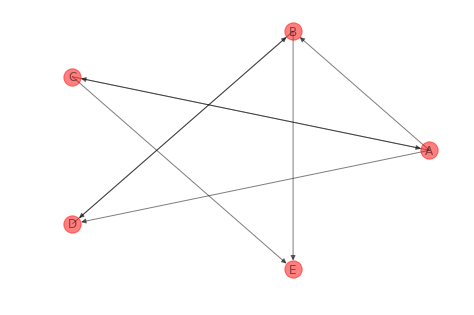

In [39]:
# part a - simple visualization of our test graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY2_GRAPH['nodes'])
G.add_edges_from(TOY2_GRAPH['edges'])
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5)

In [55]:
# part a - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################
TOY2_ADJ_MATR = get_adj_matr(TOY2_GRAPH)
transition_matrix2 = TOY2_ADJ_MATR.div(TOY2_ADJ_MATR.sum(axis = 1), axis = 0)

xInit2 = np.array([1.0, 0, 0, 0, 0])
states = power_iteration(xInit2, transition_matrix2, 10, verbose = True)
################ (END) YOUR CODE #################

Step 1 [nan nan nan nan nan]
Step 2 [nan nan nan nan nan]
Step 3 [nan nan nan nan nan]
Step 4 [nan nan nan nan nan]
Step 5 [nan nan nan nan nan]
Step 6 [nan nan nan nan nan]
Step 7 [nan nan nan nan nan]
Step 8 [nan nan nan nan nan]
Step 9 [nan nan nan nan nan]
Step 10 [nan nan nan nan nan]


# About the Data

The main dataset for this data consists of a subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis. You can read more here:

https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data.

As in previous homeworks we'll be using a 2GB subset of this data, which is available to you in this dropbox folder:

https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0.

Use the cells below to download the wikipedia data and a test file for use in developing your PageRank implementation(note that we'll use the 'indexed out' version of the graph) and to take a look at the files.

In [47]:
# create a data directory (RUN THIS CELL AS IS)
!mkdir data

In [48]:
# download the test data set (RUN THIS CELL AS IS)
!wget -q -O data/test_graph.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AACf_33TeM7rKfEhjEoNmMCaa/PageRank-test_indexed.txt?dl=0

In [49]:
# take a look
!cat data/test_graph.txt

2	{'3': 1}
3	{'2': 1}
4	{'1': 1, '2': 1}
5	{'4': 1, '2': 1, '6': 1}
6	{'2': 1, '5': 1}
7	{'2': 1, '5': 1}
8	{'2': 1, '5': 1}
9	{'2': 1, '5': 1}
10	{'5': 1}
11	{'5': 1}


In [50]:
# download the main data set - this may take a little time (RUN THIS CELL AS IS)
!wget -O data/wiki_graph.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt?dl=0

--2018-11-14 00:56:47--  https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt?dl=0
Resolving www.dropbox.com... 162.125.7.1, 2620:100:601a:1:ffff:ffff:a27d:701
Connecting to www.dropbox.com|162.125.7.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt [following]
--2018-11-14 00:56:47--  https://www.dropbox.com/sh/raw/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1af7b8143eb218e3795fc3ccd7.dl.dropboxusercontent.com/cd/0/inline/AVhxlZ_iBOQQCyYGhhBiOSQq1IRjJ4YOYdo9tg7qshiDJqm0CWwM1bo_V4L9SCIbmkLrsdir38w9hPMzaHohGfa2Uv-ejm9PdGK6uh_mbHuKNWI3aSWVPNsvrAOLih04gBH0f3Q-RuVOQnqZ6E6hy6M8f2mfzoPT9KJpdKCZJMbpav5NP60WOcPJggIcUsuIG7o/file [following]
--2018-11-14 00:56:48--

In [51]:
# take a look (RUN THIS CELL AS IS)
!head data/wiki_graph.txt

73	{'14417532': 1}
299	{'4214575': 1}
2552	{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}
2570	{'983991': 1}
2616	{'9045350': 1}
2711	{'752887': 1}
2818	{'3534183': 1}
2847	{'3797918': 1}
2892	{'2893': 1}
2921	{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}


In [52]:
# download the indexes (RUN THIS CELL AS IS)
!wget -q -O data/indices.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AADSYhyRXbgebRDy6ALl6O1ca/wikipedia/indices.txt?dl=0

In [10]:
# take a look (RUN THIS CELL AS IS)
!head data/indices.txt

! $var = &quot;&quot;	1	1	0
! (CONFIG.SYS directive)	2	1	1
! (album)	3	12	17
! (disambiguation)	4	1	20
! -attention-	5	1	0
! Time Zone	6	1	0
!! (chess)	7	0	1
!! (disambiguation)	8	3	0
!!! (Chk Chk Chk)	9	1	0
!!! (album)	10	5	15


In [19]:
!grep -P '\t2552\t' data/indices.txt

&quot;A&quot; Device	2552	11	21
Botafogo de Futebol e Regatas	2108340	2552	169
Justin Bieber	6855157	2552	400
Middlesbrough	8764241	2552	420


In [5]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
testRDD = sc.textFile('data/test_graph.txt')
indexRDD = sc.textFile('data/indices.txt')
wikiRDD = sc.textFile('data/wiki_graph.txt')

# Question 5: EDA part 1 (number of nodes)

As usual, before we dive in to the main analysis, we'll peform some exploratory data anlysis to understand our dataset. Please use the test graph that you downloaded to test all your code before running the full dataset.

### Q5 Tasks:
* __a) short response:__ In what format is the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]

* __b) code + short response:__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.

* __c) code:__ In the space provided below write a Spark job to count the _total number_ of nodes in this graph. 

* __d) short response:__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]

### Q5 Student Answers:
> __a)__ The first value is the node. And the second part of each line is a dictionary of {destination node: number of paths}

> __b)__ The number of records is just number of nodes that have an outgoing path. There could be many dangling nodes. 

> __d)__ There are 9410987 dangling nodes


In [59]:
# part b - count the number of records in the raw data (RUN THIS CELL AS IS)
!wc -l data/wiki_graph.txt

5781290 data/wiki_graph.txt


In [70]:
# part c - write your Spark job here (compute total number of nodes)
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############
    def splitnodes(pair):
        key, value = pair
        yield (key)
        for node in ast.literal_eval(value).keys():
            yield (node)
    
    totalCount = dataRDD.map(lambda line: line.split('\t')) \
                          .flatMap(splitnodes) \
                          .distinct() \
                          .count()
            
    ############## (END) YOUR CODE ###############   
    return totalCount

In [71]:
# part c - run your counting job on the test file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(testRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 0.23550677299499512 seconds.
Total Nodes: 11


In [72]:
# part c - run your counting job on the full file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(wikiRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 425.91476035118103 seconds.
Total Nodes: 15192277


In [73]:
tot - 5781290

9410987

# Question 6 - EDA part 2 (out-degree distribution)

As you've seen in previous homeworks the computational complexity of an implementation depends not only on the number of records in the original dataset but also on the number of records we create and shuffle in our intermediate representation of the data. The number of intermediate records required to update PageRank is related to the number of edges in the graph. In this question you'll compute the average number of hyperlinks on each page in this data and visualize a distribution for these counts (the out-degree of the nodes). 

### Q6 Tasks:
* __a) code:__ In the space provided below write a Spark job to stream over the data and compute all of the following information:
 * count the out-degree of each non-dangling node and return the names of the top 10 pages with the most hyperlinks
 * find the average out-degree for all non-dangling nodes in the graph
 * take a 1000 point sample of these out-degree counts and plot a histogram of the result. 
 
 
* __b) short response:__ In the context of the PageRank algorithm, how is information about a node's out degree used?

* __c) short response:__ What does it mean if a node's out-degree is 0? In PageRank how will we handle these nodes differently than others?
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q6 Student Answers:

> __b)__ Node's out degree is used to compute the distribution of the probabilily mass the node passes to its linked nodes.

> __c)__ If a node's out-degree is 0 then it's a dnagling node. In pagerank we will distribute the probability of such node evenly to every node in the global space

In [101]:
# part a - write your Spark job here (compute average in-degree, etc)
def count_degree(dataRDD, n):
    """
    Function to analyze out-degree of nodes in a a graph.
    Returns: 
        top  - (list of 10 tuples) nodes with most edges
        avgDegree - (float) average out-degree for non-dangling nodes
        sampledCounts - (list of integers) out-degree for n randomly sampled non-dangling nodes
    """
    # helper func
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    ############## YOUR CODE HERE ###############
    #function to yield node and count of outgoing paths for each linked node
    def yield_links_count(pair):
        node, edges = pair
        for count in edges.values():
            yield (node, count)
    
    outDegreeRDD = dataRDD.map(parse) \
                       .flatMap(yield_links_count) \
                       .reduceByKey(lambda x,y : x+y) \
                       .cache()
    
    top = list(map(lambda x: x[0], outDegreeRDD.takeOrdered(n, key = lambda x: -x[1])))
    
    avgDegree = outDegreeRDD.map(lambda x: x[1]).mean()
                    
    sampledCounts = outDegreeRDD.map(lambda x: x[1]) \
                                .takeSample(True, 1000)
    
    ############## (END) YOUR CODE ###############
    
    return top, avgDegree, sampledCounts

... completed job in 4.462301969528198 seconds
Average out-degree:  1.7
Top 10 nodes (by out-degree:)
 ['5', '4', '8', '9', '6', '7', '10', '2', '3', '11']


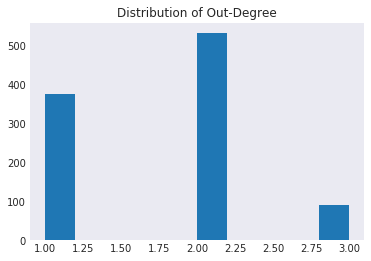

In [102]:
# part a - run your job on the test file (RUN THIS CELL AS IS)
start = time.time()
test_results = count_degree(testRDD,10)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])
plt.hist(test_results[2], bins=10)
plt.title("Distribution of Out-Degree")
plt.show()

... completed job in 290.65615797042847 seconds
Average out-degree:  32.041815753923466
Top 10 nodes (by out-degree:)
 ['7804599', '7858931', '11185362', '7705822', '5760310', '7865920', '7819767', '7883280', '13035895', '7880980', '7909437', '7810869', '7846493', '7841582', '7768780', '7820711', '7861935', '6075450', '7884831', '7777185', '7803276', '6074992', '434078', '7828359', '7773411', '7834538', '10526976', '7828391', '1008643', '7873008', '7812439', '7881486', '7773479', '7820535', '7871067', '7882833', '7902703', '7847103', '5988470', '7872661', '7914303', '5988469', '7848337', '11670785', '7884903', '6075178', '6075732', '7831837', '7839409', '6835653', '7803274', '7785602', '9643124', '7911689', '9643132', '7887218', '7911235', '7884931', '7727417', '7810198', '7854241', '10852744', '7848322', '7850777', '7884930', '8353825', '7885241', '11670104', '7870424', '7909901', '7865253', '7832957', '7780859', '7818538', '7808359', '1499631', '7821232', '7818786', '7705731', '77308

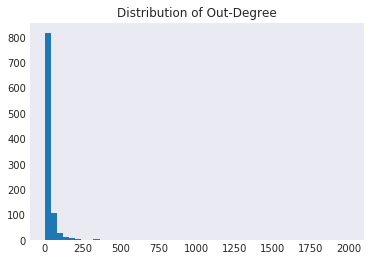

In [103]:
# part a - run your job on the full file (RUN THIS CELL AS IS)
start = time.time()
full_results = count_degree(wikiRDD,1000)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", full_results[1])
print("Top 10 nodes (by out-degree:)\n", full_results[0])
plt.hist(full_results[2], bins=50)
plt.title("Distribution of Out-Degree")
plt.show()

# Question 7 - PageRank part 1 (Initialize the Graph)

One of the challenges of performing distributed graph computation is that you must pass the entire graph structure through each iteration of your algorithm. As usual, we seek to design our computation so that as much work as possible can be done using the contents of a single record. In the case of PageRank, we'll need each record to include a node, its list of neighbors and its (current) rank. In this question you'll initialize the graph by creating a record for each dangling node and by setting the initial rank to 1/N for all nodes. 

__`NOTE:`__ Your solution should _not_ hard code $N$.

### Q7 Tasks:
* __a) short response:__ What is $N$? Use the analogy of the infinite random web-surfer to explain why we'll initialize each node's rank to $\frac{1}{N}$. (i.e. what is the probabilistic interpretation of this choice?)

* __b) short response:__ Will it be more efficient to compute $N$ before initializing records for each dangling node or after? Explain your reasoning.

* __c) code:__ Fill in the missing code below to create a Spark job that:
  * parses each input record
  * creates a new record for any dangling nodes and sets it list of neighbors to be an empty set
  * initializes a rank of 1/N for each node
  * returns a pair RDD with records in the format specified by the docstring


* __d) code:__ Run the provided code to confirm that your job in `part a` has a record for each node and that your should records match the format specified in the docstring and the count should match what you computed in question 5. [__`TIP:`__ _you might want to take a moment to write out what the expected output should be fore the test graph, this will help you know your code works as expected_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q7 Student Answers:

> __a)__ N is the total number of nodes. As we initialize each node's rank to 1/N, it means that the probability of a random surfer arriving at each node is the same. 

> __b)__ It'll be more efficient to compute the N after initializing records for each dangling node since it will just be a count of records. Or else, we will need to do a pass at each record and count the distinct node that we encounter. 

In [9]:
# part c - job to initialize the graph (RUN THIS CELL AS IS)
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############

    # write any helper functions here
    #parse line
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    #yield items for adjacency list
    def yield_adj_list(pair):
        node, edges = pair
        for edge in edges.keys():
            yield(node, [edge])
            yield(edge, [])
    
    
    # write your main Spark code here
    tempRDD = dataRDD.map(parse) \
                     .flatMap(yield_adj_list) \
                     .reduceByKey(lambda x,y : x+y) \
                     .cache()
    
    N = tempRDD.count()
    
    graphRDD = tempRDD.map(lambda x: (x[0], (1/N, x[1])))
    
    ############## (END) YOUR CODE ##############
    
    return graphRDD

In [7]:
# part c - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph = initGraph(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

... test graph initialized in 2.3147025108337402 seconds.


[('4', (0.09090909090909091, ['1', '2'])),
 ('1', (0.09090909090909091, [])),
 ('8', (0.09090909090909091, ['2', '5'])),
 ('9', (0.09090909090909091, ['2', '5'])),
 ('10', (0.09090909090909091, ['5'])),
 ('2', (0.09090909090909091, ['3'])),
 ('3', (0.09090909090909091, ['2'])),
 ('5', (0.09090909090909091, ['4', '2', '6'])),
 ('6', (0.09090909090909091, ['2', '5'])),
 ('7', (0.09090909090909091, ['2', '5'])),
 ('11', (0.09090909090909091, ['5']))]

In [12]:
# part c - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
wikiGraphRDD = initGraph(wikiRDD)
print(f'... full graph initialized in {time.time() - start} seconds')

... full graph initialized in 735.1502938270569 seconds


In [9]:
# part c - confirm record format and count (RUN THIS CELL AS IS)
start = time.time()
print(f'Total number of records: {wikiGraphRDD.count()}')
print(f'First record: {wikiGraphRDD.take(1)}')
print(f'... initialization continued: {time.time() - start} seconds')

Total number of records: 15192277
First record: [('11777840', (6.582291778908455e-08, ['6127245', '5158607', '757856', '14772413', '14803224', '6905109', '10666321', '6007184', '12469293', '14773825', '9343079', '8892083', '13077979', '9285165', '14978814', '6420484', '9789784', '14482968', '981395', '2921', '15173803', '12617777', '7021832', '2335603', '14484050', '9922389', '11023778', '2344940', '6905766', '9447742', '6557458', '1425342', '9660994', '11390944', '14261593', '14928135', '14841606', '14765621', '12530354', '2335868', '13636570', '2335876', '9827642', '15105458', '9501013', '11101298', '9395391', '6416278', '15018227', '8024321', '11656072', '5165182', '6420027', '7337035', '14712897', '10898196', '15161507', '535091', '5595377', '1725688', '14183835', '1402856', '1398329', '14670682', '14210235', '11696376', '15087242', '14900113', '7316613', '12071841', '12048800', '14624941', '5789809', '11497740']))]
... initialization continued: 263.34146332740784 seconds


# Question 8 - PageRank part 2 (Iterate until convergence)

Finally we're ready to compute the page rank. In this last question you'll write a Spark job that iterates over the initialized graph updating each nodes score until it reaches a convergence threshold. The diagram below gives a visual overview of the process using a 5 node toy graph. Pay particular attention to what happens to the dangling mass at each iteration.

<img src='PR-illustrated.png'>



__`A Note about Notation:`__ The formula above describes how to compute the updated page rank for a node in the graph. The $P$ on the left hand side of the equation is the new score, and the $P$ on the right hand side of the equation represents the accumulated mass that was re-distributed from all of that node's in-links. Finally, $|G|$ is the number of nodes in the graph (which we've elsewhere refered to as $N$).

### Q8 Tasks:
* __a) short response:__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: $\alpha * \frac{1}{|G|}$

* __b) short response:__ In the equation for the PageRank calculation above what does $m$ represent and why do we divide it by $|G|$?

* __c) short response:__ Keeping track of the total probability mass after each update is a good way to confirm that your algorithm is on track. How much should the total mass be after each iteration?

* __d) code:__ Fill in the missing code below to create a Spark job that take the initialized graph as its input then iterates over the graph and for each pass:
  * reads in each record and redistributes the node's current score to each of its neighbors
  * uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (_Don't forget to reset this accumulator after each iteration!_)
  * uses an accumulator to keep track of the total mass being redistributed.( _This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration._)
  * aggregates these partial scores for each node
  * applies telportation and damping factors as described in the formula above.
  * combine all of the above to compute the PageRank as described by the formula above.
  * 
  
   __WARNING:__ Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.

 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q8 Student Answers:

> __a)__ $\alpha * \frac{1}{|G|}$ part of the equation accomodates for the probability distribution for each node to be landed from a teleportation. In terms of the infinite random walk analgy, that just calculates the average time spent on each node that was landed from a teleportation.  

> __b)__ m represents the probabilily mass acumulated at the dangling nodes. Through dividing it by |G| we distributes the probability mass on these nodes equally on every node in the graph, making the graph irreducible in order for the ditribution to converge. 

> __c)__ The total mass should be 1 after each iteration

In [6]:
# part d - provided FloatAccumulator class (RUN THIS CELL AS IS)

from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [7]:
# part d - job to run PageRank (RUN THIS CELL AS IS)
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0)
    totAccum = sc.accumulator(0.0)
    
    ############## YOUR CODE HERE ###############
    
    # write your helper functions here, 
    # please document the purpose of each clearly 
    # for reference, the master solution has 5 helper functions.
    
    #accumulate dangling node mass
    def accum_dangling_mass (graph):
        node, (mass, neighbors) = graph
        if neighbors == []:
            mmAccum.add(float(mass))
            
    #redistribute probability and 
    def redist_prob (graph):

        node, (mass, neighbors) = graph
        N = len(neighbors)

        #for dangling node, yield 0 mass
        if N == 0:
            yield (node, (0, []))
        
        #for non-dangling node, yield self and neighbors with distributed mass
        elif N > 0:
            #initialize 1/n for each node
            for neighbor in neighbors:
                yield(neighbor, (mass / N, []))
            #self
            yield (node, (0, neighbors))
      
    #distribute dangling node mass to every node
    def combine_mass (graph):
        node, (mass, neighbors) = graph
        dist_d_mass = dang_mass/G
        
        yield (node, (a.value * (1/G) + d.value * (mass + dist_d_mass), neighbors))
    
    #accumulate total redistributed mass
    def accum_total_mass (graph):
        node, (mass, neighbors) = graph
        totAccum.add(float(mass))
        
    
    # write your main Spark Job here (including the for loop to iterate)
    # for reference, the master solution is 21 lines including comments & whitespace
    
    #total nodes in graph
    G = graphInitRDD.count()
    prepRdd = graphInitRDD
    
    #step1: distribute mass to neighbors
    for i in range(maxIter):
        
        #step0: accumulate dangling mass
        prepRdd.foreach(accum_dangling_mass)
        dang_mass = mmAccum.value
        if verbose:
            print ('dangling mass:', mmAccum)
        mmAccum = sc.accumulator(0.0)
        
        #step 1: redistribute mass
        step1Rdd = prepRdd.flatMap(redist_prob) \
                               .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])) \
                               .cache()

        #step 2: combine mass for nodes 
        step2Rdd = step1Rdd.flatMap(combine_mass).cache()
        
        #step 3: accumulate total mass
        step2Rdd.foreach(accum_total_mass)
        if verbose:
            print ('total mass:', totAccum)
        totAccum = sc.accumulator(0.0)
        
        prepRdd = step2Rdd
    
    steadyStateRDD = prepRdd.map(lambda x: (x[0], x[1][0]))
    
    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

In [10]:
# part d - run PageRank on the test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 20
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = False)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: - x[1])

...trained 20 iterations in 8.972902536392212 seconds.
Top 20 ranked nodes:


[('2', 0.38031552249156747),
 ('3', 0.3469932932917439),
 ('5', 0.08088637369406641),
 ('4', 0.039087602168414746),
 ('6', 0.039087602168414746),
 ('1', 0.032781877034008526),
 ('8', 0.01616954583035677),
 ('9', 0.01616954583035677),
 ('10', 0.01616954583035677),
 ('7', 0.01616954583035677),
 ('11', 0.01616954583035677)]

__`expected results for the test graph:`__
```
(2, 0.3803155224915675)
(3, 0.3469932932917439)
(5, 0.08088637369406641)
(4, 0.039087602168414746)
(6, 0.039087602168414746)
(1, 0.032781877034008526)
(8, 0.01616954583035677)
(10, 0.01616954583035677)
(7, 0.01616954583035677)
(9, 0.01616954583035677)
(11, 0.01616954583035677)
```

In [14]:
# part d - run PageRank on the full graph (RUN THIS CELL AS IS)
# NOTE: wikiGraphRDD should have been computed & cached above!
nIter = 10
start = time.time()
full_results = runPageRank(wikiGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
full_results.takeOrdered(20, key=lambda x: - x[1])

Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
com.databricks#spark-xml_2.11 added as a dependency
graphframes#graphframes added as a dependency
com.databricks#spark-avro_2.11 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent;1.0
	confs: [default]
	found com.databricks#spark-xml_2.11;0.4.1 in central
	found graphframes#graphframes;0.5.0-spark2.1-s_2.11 in spark-packages
	found com.typesafe.scala-logging#scala-logging-api_2.11;2.1.2 in central
	found com.typesafe.scala-logging#scala-logging-slf4j_2.11;2.1.2 in central
	found org.scala-lang#scala-reflect;2.11.0 in central
	found org.slf4j#slf4j-api;1.7.7 in central
	found com.databricks#spark-avro_2.11;4.0.0 in central
	found org.apache.avro#avro;1.7.6 in central
	found org.codehaus.jackson#jackson-core-asl;1.9.13 in central
	found org.codehaus.jackson#jackson-mapper-asl;1.9.13 in central
	found com.thoughtworks.paranamer#paranamer;2.3 in central
	found org.xerial.snappy#snappy-java;1.0.5 in central
	found org.apache.commons#commons-compress;1.4.1 in central
	found org.tukaani#xz;1.0 in central
downloading https://repo1.maven.org/maven2/com/databricks/spark-xml_2.11/0.4.1/spark-xml_2.11-0.4.1.jar ...
	[SUCCESSFUL ] com.databricks#spark-xml_2.11;0.4.1!spark-xml_2.11.jar (46ms)
downloading http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.5.0-spark2.1-s_2.11/graphframes-0.5.0-spark2.1-s_2.11.jar ...
	[SUCCESSFUL ] graphframes#graphframes;0.5.0-spark2.1-s_2.11!graphframes.jar (181ms)
downloading https://repo1.maven.org/maven2/com/databricks/spark-avro_2.11/4.0.0/spark-avro_2.11-4.0.0.jar ...
	[SUCCESSFUL ] com.databricks#spark-avro_2.11;4.0.0!spark-avro_2.11.jar (23ms)
downloading https://repo1.maven.org/maven2/com/typesafe/scala-logging/scala-logging-api_2.11/2.1.2/scala-logging-api_2.11-2.1.2.jar ...
	[SUCCESSFUL ] com.typesafe.scala-logging#scala-logging-api_2.11;2.1.2!scala-logging-api_2.11.jar (12ms)
downloading https://repo1.maven.org/maven2/com/typesafe/scala-logging/scala-logging-slf4j_2.11/2.1.2/scala-logging-slf4j_2.11-2.1.2.jar ...
	[SUCCESSFUL ] com.typesafe.scala-logging#scala-logging-slf4j_2.11;2.1.2!scala-logging-slf4j_2.11.jar (13ms)
downloading https://repo1.maven.org/maven2/org/scala-lang/scala-reflect/2.11.0/scala-reflect-2.11.0.jar ...
	[SUCCESSFUL ] org.scala-lang#scala-reflect;2.11.0!scala-reflect.jar (382ms)
downloading https://repo1.maven.org/maven2/org/slf4j/slf4j-api/1.7.7/slf4j-api-1.7.7.jar ...
	[SUCCESSFUL ] org.slf4j#slf4j-api;1.7.7!slf4j-api.jar (12ms)
downloading https://repo1.maven.org/maven2/org/apache/avro/avro/1.7.6/avro-1.7.6.jar ...
	[SUCCESSFUL ] org.apache.avro#avro;1.7.6!avro.jar(bundle) (42ms)
downloading https://repo1.maven.org/maven2/org/codehaus/jackson/jackson-core-asl/1.9.13/jackson-core-asl-1.9.13.jar ...
	[SUCCESSFUL ] org.codehaus.jackson#jackson-core-asl;1.9.13!jackson-core-asl.jar (28ms)
downloading https://repo1.maven.org/maven2/org/codehaus/jackson/jackson-mapper-asl/1.9.13/jackson-mapper-asl-1.9.13.jar ...
	[SUCCESSFUL ] org.codehaus.jackson#jackson-mapper-asl;1.9.13!jackson-mapper-asl.jar (67ms)
downloading https://repo1.maven.org/maven2/com/thoughtworks/paranamer/paranamer/2.3/paranamer-2.3.jar ...
	[SUCCESSFUL ] com.thoughtworks.paranamer#paranamer;2.3!paranamer.jar (13ms)
downloading https://repo1.maven.org/maven2/org/xerial/snappy/snappy-java/1.0.5/snappy-java-1.0.5.jar ...
	[SUCCESSFUL ] org.xerial.snappy#snappy-java;1.0.5!snappy-java.jar(bundle) (95ms)
downloading https://repo1.maven.org/maven2/org/apache/commons/commons-compress/1.4.1/commons-compress-1.4.1.jar ...
	[SUCCESSFUL ] org.apache.commons#commons-compress;1.4.1!commons-compress.jar (27ms)
downloading https://repo1.maven.org/maven2/org/tukaani/xz/1.0/xz-1.0.jar ...
	[SUCCESSFUL ] org.tukaani#xz;1.0!xz.jar (17ms)
:: resolution report :: resolve 3596ms :: artifacts dl 969ms
	:: modules in use:
	com.databricks#spark-avro_2.11;4.0.0 from central in [default]
	com.databricks#spark-xml_2.11;0.4.1 from central in [default]
	com.thoughtworks.paranamer#paranamer;2.3 from central in [default]
	com.typesafe.scala-logging#scala-logging-api_2.11;2.1.2 from central in [default]
	com.typesafe.scala-logging#scala-logging-slf4j_2.11;2.1.2 from central in [default]
	graphframes#graphframes;0.5.0-spark2.1-s_2.11 from spark-packages in [default]
	org.apache.avro#avro;1.7.6 from central in [default]
	org.apache.commons#commons-compress;1.4.1 from central in [default]
	org.codehaus.jackson#jackson-core-asl;1.9.13 from central in [default]
	org.codehaus.jackson#jackson-mapper-asl;1.9.13 from central in [default]
	org.scala-lang#scala-reflect;2.11.0 from central in [default]
	org.slf4j#slf4j-api;1.7.7 from central in [default]
	org.tukaani#xz;1.0 from central in [default]
	org.xerial.snappy#snappy-java;1.0.5 from central in [default]
	:: evicted modules:
	org.slf4j#slf4j-api;1.7.5 by [org.slf4j#slf4j-api;1.7.7] in [default]
	org.slf4j#slf4j-api;1.6.4 by [org.slf4j#slf4j-api;1.7.7] in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   16  |   14  |   14  |   2   ||   14  |   14  |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent
	confs: [default]
	14 artifacts copied, 0 already retrieved (7998kB/28ms)
18/11/22 23:09:30 INFO org.spark_project.jetty.util.log: Logging initialized @7764ms
18/11/22 23:09:30 INFO org.spark_project.jetty.server.Server: jetty-9.3.z-SNAPSHOT
18/11/22 23:09:30 INFO org.spark_project.jetty.server.Server: Started @7860ms
18/11/22 23:09:30 INFO org.spark_project.jetty.server.AbstractConnector: Started ServerConnector@311823c8{HTTP/1.1,[http/1.1]}{0.0.0.0:4040}
18/11/22 23:09:30 INFO com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.10-hadoop2
18/11/22 23:09:34 INFO org.apache.hadoop.mapred.FileInputFormat: Total input files to process : 1

[Stage 0:>                                                         (0 + 4) / 16]
[Stage 0:>                                                         (0 + 4) / 16]
[Stage 0:>                                                         (0 + 4) / 16]
[Stage 0:>                                                         (0 + 4) / 16]
[Stage 0:===>                                                      (1 + 4) / 16]
[Stage 0:=======>                                                  (2 + 4) / 16]
[Stage 0:==========>                                               (3 + 4) / 16]
[Stage 0:==============>                                           (4 + 4) / 16]
[Stage 0:==============>                                           (4 + 4) / 16]
[Stage 0:==============>                                           (4 + 4) / 16]
[Stage 0:==============>                                           (4 + 4) / 16]
[Stage 0:==================>                                       (5 + 4) / 16]
[Stage 0:=====================>                                    (6 + 4) / 16]
[Stage 0:=========================>                                (7 + 4) / 16]
[Stage 0:=============================>                            (8 + 4) / 16]
[Stage 0:=============================>                            (8 + 4) / 16]
[Stage 0:=============================>                            (8 + 4) / 16]
[Stage 0:=============================>                            (8 + 4) / 16]
[Stage 0:===================================>                     (10 + 4) / 16]
[Stage 0:=======================================>                 (11 + 4) / 16]
[Stage 0:==========================================>              (12 + 4) / 16]
[Stage 0:==========================================>              (12 + 4) / 16]
[Stage 0:==========================================>              (12 + 4) / 16]
[Stage 0:==============================================>          (13 + 3) / 16]
[Stage 0:==============================================>          (13 + 3) / 16]
[Stage 0:=================================================>       (14 + 2) / 16]
[Stage 0:=====================================================>   (15 + 1) / 16]
[Stage 1:>                                                         (0 + 4) / 16]
[Stage 1:>                                                         (0 + 4) / 16]
[Stage 1:=======>                                                  (2 + 4) / 16]
[Stage 1:==========>                                               (3 + 4) / 16]
[Stage 1:==============>                                           (4 + 4) / 16]
[Stage 1:==============>                                           (4 + 4) / 16]
[Stage 1:==================>                                       (5 + 4) / 16]
[Stage 1:=====================>                                    (6 + 4) / 16]
[Stage 1:=========================>                                (7 + 4) / 16]
[Stage 1:=============================>                            (8 + 4) / 16]
[Stage 1:=============================>                            (8 + 4) / 16]
[Stage 1:================================>                         (9 + 4) / 16]
[Stage 1:=======================================>                 (11 + 4) / 16]
[Stage 1:==========================================>              (12 + 4) / 16]
[Stage 1:==========================================>              (12 + 4) / 16]18/11/22 23:29:54 WARN org.apache.spark.storage.memory.MemoryStore: Not enough space to cache rdd_6_15 in memory! (computed 89.3 MB so far)
18/11/22 23:29:54 WARN org.apache.spark.storage.memory.MemoryStore: Not enough space to cache rdd_6_14 in memory! (computed 96.8 MB so far)
18/11/22 23:29:54 WARN org.apache.spark.storage.BlockManager: Block rdd_6_15 could not be removed as it was not found on disk or in memory
18/11/22 23:29:54 WARN org.apache.spark.storage.BlockManager: Putting block rdd_6_15 failed
18/11/22 23:29:54 WARN org.apache.spark.storage.BlockManager: Block rdd_6_14 could not be removed as it was not found on disk or in memory
18/11/22 23:29:54 WARN org.apache.spark.storage.BlockManager: Putting block rdd_6_14 failed
18/11/22 23:29:54 WARN org.apache.spark.storage.memory.MemoryStore: Not enough space to cache rdd_6_13 in memory! (computed 95.5 MB so far)
18/11/22 23:29:54 WARN org.apache.spark.storage.BlockManager: Block rdd_6_13 could not be removed as it was not found on disk or in memory
18/11/22 23:29:54 WARN org.apache.spark.storage.BlockManager: Putting block rdd_6_13 failed

[Stage 1:==============================================>          (13 + 3) / 16]
[Stage 1:=====================================================>   (15 + 1) / 16]
                                                                                

[Stage 3:>                                                         (0 + 4) / 16]
[Stage 3:===>                                                      (1 + 4) / 16]
[Stage 3:==========>                                               (3 + 4) / 16]
[Stage 3:==============>                                           (4 + 4) / 16]
[Stage 3:=====================>                                    (6 + 4) / 16]
[Stage 3:=========================>                                (7 + 4) / 16]
[Stage 3:=============================>                            (8 + 4) / 16]
[Stage 3:===================================>                     (10 + 4) / 16]
[Stage 3:=======================================>                 (11 + 4) / 16]
[Stage 3:==========================================>              (12 + 4) / 16]
[Stage 3:==============================================>          (13 + 3) / 16]
[Stage 3:==============================================>          (13 + 3) / 16]18/11/22 23:31:17 WARN org.apache.spark.storage.memory.MemoryStore: Not enough space to cache rdd_6_13 in memory! (computed 84.6 MB so far)
18/11/22 23:31:17 WARN org.apache.spark.storage.memory.MemoryStore: Not enough space to cache rdd_6_14 in memory! (computed 93.9 MB so far)
18/11/22 23:31:17 WARN org.apache.spark.storage.BlockManager: Block rdd_6_14 could not be removed as it was not found on disk or in memory
18/11/22 23:31:17 WARN org.apache.spark.storage.BlockManager: Putting block rdd_6_14 failed
18/11/22 23:31:17 WARN org.apache.spark.storage.memory.MemoryStore: Not enough space to cache rdd_6_15 in memory! (computed 103.2 MB so far)
18/11/22 23:31:17 WARN org.apache.spark.storage.BlockManager: Block rdd_6_13 could not be removed as it was not found on disk or in memory
18/11/22 23:31:17 WARN org.apache.spark.storage.BlockManager: Putting block rdd_6_13 failed
18/11/22 23:31:17 WARN org.apache.spark.storage.BlockManager: Block rdd_6_15 could not be removed as it was not found on disk or in memory
18/11/22 23:31:17 WARN org.apache.spark.storage.BlockManager: Putting block rdd_6_15 failed

[Stage 3:=================================================>       (14 + 2) / 16]
[Stage 3:=====================================================>   (15 + 1) / 16]
                                                                                

[Stage 5:>                                                         (0 + 4) / 16]
[Stage 5:==============>                                           (4 + 4) / 16]
[Stage 5:=====================>                                    (6 + 4) / 16]
[Stage 5:=========================>                                (7 + 5) / 16]
[Stage 5:=============================>                            (8 + 4) / 16]
[Stage 5:================================>                         (9 + 4) / 16]
[Stage 5:===================================>                     (10 + 4) / 16]
[Stage 5:=======================================>                 (11 + 4) / 16]
[Stage 5:==========================================>              (12 + 4) / 16]
[Stage 5:==============================================>          (13 + 3) / 16]
[Stage 5:==============================================>          (13 + 3) / 16]18/11/22 23:32:44 WARN org.apache.spark.storage.memory.MemoryStore: Not enough space to cache rdd_6_14 in memory! (computed 94.4 MB so far)
18/11/22 23:32:44 WARN org.apache.spark.storage.BlockManager: Block rdd_6_14 could not be removed as it was not found on disk or in memory
18/11/22 23:32:44 WARN org.apache.spark.storage.BlockManager: Putting block rdd_6_14 failed
18/11/22 23:32:44 WARN org.apache.spark.storage.memory.MemoryStore: Not enough space to cache rdd_6_15 in memory! (computed 85.6 MB so far)
18/11/22 23:32:44 WARN org.apache.spark.storage.BlockManager: Block rdd_6_15 could not be removed as it was not found on disk or in memory
18/11/22 23:32:44 WARN org.apache.spark.storage.BlockManager: Putting block rdd_6_15 failed
18/11/22 23:32:44 WARN org.apache.spark.storage.memory.MemoryStore: Not enough space to cache rdd_6_13 in memory! (computed 102.2 MB so far)
18/11/22 23:32:44 WARN org.apache.spark.storage.BlockManager: Block rdd_6_13 could not be removed as it was not found on disk or in memory
18/11/22 23:32:44 WARN org.apache.spark.storage.BlockManager: Putting block rdd_6_13 failed

[Stage 5:=================================================>       (14 + 2) / 16]
[Stage 5:=====================================================>   (15 + 1) / 16]
                                                                                
dangling mass: 0.6194586236216251

[Stage 7:>                                                         (0 + 4) / 16]
[Stage 7:>                                                         (0 + 4) / 16]
[Stage 7:>                                                         (0 + 4) / 16]
[Stage 7:>                                                         (0 + 4) / 16]
[Stage 7:===>                                                      (1 + 4) / 16]
[Stage 7:=======>                                                  (2 + 4) / 16]
[Stage 7:==========>                                               (3 + 4) / 16]
[Stage 7:==============>                                           (4 + 4) / 16]
[Stage 7:==============>                                           (4 + 4) / 16]
[Stage 7:==============>                                           (4 + 4) / 16]
[Stage 7:==============>                                           (4 + 4) / 16]
[Stage 7:==================>                                       (5 + 4) / 16]
[Stage 7:=====================>                                    (6 + 4) / 16]
[Stage 7:=========================>                                (7 + 4) / 16]
[Stage 7:=============================>                            (8 + 4) / 16]
[Stage 7:=============================>                            (8 + 4) / 16]
[Stage 7:=============================>                            (8 + 4) / 16]
[Stage 7:=============================>                            (8 + 4) / 16]
[Stage 7:================================>                         (9 + 4) / 16]
[Stage 7:===================================>                     (10 + 4) / 16]
[Stage 7:=======================================>                 (11 + 4) / 16]
[Stage 7:==========================================>              (12 + 4) / 16]
[Stage 7:==========================================>              (12 + 4) / 16]18/11/22 23:44:38 WARN org.apache.spark.storage.memory.MemoryStore: Not enough space to cache rdd_6_13 in memory! (computed 111.6 MB so far)
18/11/22 23:44:38 WARN org.apache.spark.storage.BlockManager: Block rdd_6_13 could not be removed as it was not found on disk or in memory
18/11/22 23:44:38 WARN org.apache.spark.storage.BlockManager: Putting block rdd_6_13 failed
18/11/22 23:44:38 WARN org.apache.spark.storage.memory.MemoryStore: Not enough space to cache rdd_6_15 in memory! (computed 76.2 MB so far)
18/11/22 23:44:38 WARN org.apache.spark.storage.BlockManager: Block rdd_6_15 could not be removed as it was not found on disk or in memory
18/11/22 23:44:38 WARN org.apache.spark.storage.BlockManager: Putting block rdd_6_15 failed
18/11/22 23:44:38 WARN org.apache.spark.storage.memory.MemoryStore: Not enough space to cache rdd_6_14 in memory! (computed 93.7 MB so far)
18/11/22 23:44:38 WARN org.apache.spark.storage.BlockManager: Block rdd_6_14 could not be removed as it was not found on disk or in memory
18/11/22 23:44:38 WARN org.apache.spark.storage.BlockManager: Putting block rdd_6_14 failed

[Stage 7:==========================================>              (12 + 4) / 16]
[Stage 7:==========================================>              (12 + 4) / 16]
[Stage 7:==============================================>          (13 + 3) / 16]
[Stage 7:==============================================>          (13 + 3) / 16]
[Stage 7:=================================================>       (14 + 2) / 16]
[Stage 7:=====================================================>   (15 + 1) / 16]
[Stage 8:>                                                         (0 + 4) / 16]
[Stage 8:>                                                         (0 + 4) / 16]
[Stage 8:>                                                         (0 + 4) / 16]
[Stage 8:===>                                                      (1 + 4) / 16]
[Stage 8:=======>                                                  (2 + 4) / 16]
[Stage 8:==========>                                               (3 + 4) / 16]
[Stage 8:==============>                                           (4 + 4) / 16]
[Stage 8:==============>                                           (4 + 4) / 16]
[Stage 8:==================>                                       (5 + 4) / 16]
[Stage 8:=====================>                                    (6 + 4) / 16]
[Stage 8:=========================>                                (7 + 4) / 16]
[Stage 8:=============================>                            (8 + 4) / 16]
[Stage 8:=============================>                            (8 + 4) / 16]
[Stage 8:================================>                         (9 + 4) / 16]
[Stage 8:===================================>                     (10 + 4) / 16]
[Stage 8:=======================================>                 (11 + 4) / 16]
[Stage 8:==========================================>              (12 + 4) / 16]
[Stage 8:==========================================>              (12 + 4) / 16]
[Stage 8:==============================================>          (13 + 3) / 16]
[Stage 8:=================================================>       (14 + 2) / 16]
[Stage 8:=====================================================>   (15 + 1) / 16]
                                                                                
total mass: 1.000000000004389

[Stage 11:>                                                        (0 + 4) / 16]
[Stage 11:==========>                                              (3 + 4) / 16]
[Stage 11:==============>                                          (4 + 4) / 16]
[Stage 11:=================>                                       (5 + 4) / 16]
[Stage 11:========================>                                (7 + 4) / 16]
[Stage 11:============================>                            (8 + 4) / 16]
[Stage 11:============================>                            (8 + 4) / 16]
[Stage 11:================================>                        (9 + 4) / 16]
[Stage 11:===================================>                    (10 + 4) / 16]
[Stage 11:======================================>                 (11 + 4) / 16]
[Stage 11:==========================================>             (12 + 4) / 16]
[Stage 11:==========================================>             (12 + 4) / 16]
[Stage 11:=============================================>          (13 + 3) / 16]
[Stage 11:=================================================>      (14 + 2) / 16]
[Stage 11:====================================================>   (15 + 1) / 16]
                                                                                
dangling mass: 0.5008445418027563

[Stage 14:>                                                        (0 + 4) / 16]
[Stage 14:>                                                        (0 + 4) / 16]
[Stage 14:>                                                        (0 + 4) / 16]
[Stage 14:>                                                        (0 + 4) / 16]
[Stage 14:===>                                                     (1 + 4) / 16]
[Stage 14:=======>                                                 (2 + 4) / 16]
[Stage 14:==========>                                              (3 + 4) / 16]
[Stage 14:==============>                                          (4 + 4) / 16]
[Stage 14:==============>                                          (4 + 4) / 16]
[Stage 14:==============>                                          (4 + 4) / 16]
[Stage 14:==============>                                          (4 + 4) / 16]
[Stage 14:=================>                                       (5 + 4) / 16]
[Stage 14:=====================>                                   (6 + 4) / 16]
[Stage 14:========================>                                (7 + 4) / 16]
[Stage 14:============================>                            (8 + 4) / 16]
[Stage 14:============================>                            (8 + 4) / 16]
[Stage 14:============================>                            (8 + 4) / 16]
[Stage 14:============================>                            (8 + 4) / 16]
[Stage 14:============================>                            (8 + 4) / 16]
[Stage 14:============================>                            (8 + 4) / 16]
[Stage 14:================================>                        (9 + 4) / 16]
[Stage 14:===================================>                    (10 + 4) / 16]
[Stage 14:======================================>                 (11 + 4) / 16]
[Stage 14:==========================================>             (12 + 4) / 16]
[Stage 14:==========================================>             (12 + 4) / 16]
[Stage 14:==========================================>             (12 + 4) / 16]
[Stage 14:==========================================>             (12 + 4) / 16]
[Stage 14:==========================================>             (12 + 4) / 16]
[Stage 14:==========================================>             (12 + 4) / 16]
[Stage 14:=============================================>          (13 + 3) / 16]
[Stage 14:=================================================>      (14 + 2) / 16]
[Stage 14:====================================================>   (15 + 1) / 16]
[Stage 15:>                                                        (0 + 4) / 16]
[Stage 15:>                                                        (0 + 4) / 16]
[Stage 15:>                                                        (0 + 4) / 16]
[Stage 15:===>                                                     (1 + 4) / 16]
[Stage 15:==========>                                              (3 + 4) / 16]
[Stage 15:==============>                                          (4 + 4) / 16]
[Stage 15:==============>                                          (4 + 4) / 16]
[Stage 15:=================>                                       (5 + 4) / 16]
[Stage 15:=====================>                                   (6 + 4) / 16]
[Stage 15:========================>                                (7 + 4) / 16]
[Stage 15:============================>                            (8 + 4) / 16]
[Stage 15:============================>                            (8 + 4) / 16]
[Stage 15:================================>                        (9 + 4) / 16]
[Stage 15:===================================>                    (10 + 4) / 16]
[Stage 15:======================================>                 (11 + 4) / 16]
[Stage 15:==========================================>             (12 + 4) / 16]
[Stage 15:==========================================>             (12 + 4) / 16]
[Stage 15:=============================================>          (13 + 3) / 16]
[Stage 15:=================================================>      (14 + 2) / 16]
[Stage 15:====================================================>   (15 + 1) / 16]
                                                                                
total mass: 1.000000000005093

[Stage 19:>                                                        (0 + 4) / 16]
[Stage 19:===>                                                     (1 + 4) / 16]
[Stage 19:=======>                                                 (2 + 4) / 16]
[Stage 19:==============>                                          (4 + 4) / 16]
[Stage 19:=====================>                                   (6 + 4) / 16]
[Stage 19:========================>                                (7 + 4) / 16]
[Stage 19:============================>                            (8 + 4) / 16]
[Stage 19:================================>                        (9 + 4) / 16]
[Stage 19:================================>                        (9 + 4) / 16]
[Stage 19:===================================>                    (10 + 4) / 16]
[Stage 19:======================================>                 (11 + 4) / 16]
[Stage 19:==========================================>             (12 + 4) / 16]
[Stage 19:=============================================>          (13 + 3) / 16]
[Stage 19:=============================================>          (13 + 3) / 16]
[Stage 19:=================================================>      (14 + 2) / 16]
[Stage 19:====================================================>   (15 + 1) / 16]
                                                                                
dangling mass: 0.4675425746747172

[Stage 23:>                                                        (0 + 4) / 16]
[Stage 23:>                                                        (0 + 4) / 16]
[Stage 23:>                                                        (0 + 4) / 16]
[Stage 23:>                                                        (0 + 4) / 16]
[Stage 23:===>                                                     (1 + 4) / 16]
[Stage 23:=======>                                                 (2 + 4) / 16]
[Stage 23:==========>                                              (3 + 4) / 16]
[Stage 23:==============>                                          (4 + 4) / 16]
[Stage 23:==============>                                          (4 + 4) / 16]
[Stage 23:==============>                                          (4 + 4) / 16]
[Stage 23:==============>                                          (4 + 4) / 16]
[Stage 23:=================>                                       (5 + 4) / 16]
[Stage 23:=====================>                                   (6 + 4) / 16]
[Stage 23:========================>                                (7 + 4) / 16]
[Stage 23:============================>                            (8 + 4) / 16]
[Stage 23:============================>                            (8 + 4) / 16]
[Stage 23:============================>                            (8 + 4) / 16]
[Stage 23:============================>                            (8 + 4) / 16]
[Stage 23:================================>                        (9 + 4) / 16]
[Stage 23:===================================>                    (10 + 4) / 16]
[Stage 23:======================================>                 (11 + 4) / 16]
[Stage 23:======================================>                 (11 + 4) / 16]
[Stage 23:======================================>                 (11 + 4) / 16]
[Stage 23:==========================================>             (12 + 4) / 16]
[Stage 23:==========================================>             (12 + 4) / 16]
[Stage 23:==========================================>             (12 + 4) / 16]
[Stage 23:==========================================>             (12 + 4) / 16]
[Stage 23:=============================================>          (13 + 3) / 16]
[Stage 23:=================================================>      (14 + 2) / 16]
[Stage 23:====================================================>   (15 + 1) / 16]
[Stage 23:====================================================>   (15 + 1) / 16]
[Stage 24:>                                                        (0 + 4) / 16]
[Stage 24:>                                                        (0 + 4) / 16]
[Stage 24:===>                                                     (1 + 4) / 16]
[Stage 24:=======>                                                 (2 + 4) / 16]
[Stage 24:==========>                                              (3 + 4) / 16]
[Stage 24:==============>                                          (4 + 4) / 16]
[Stage 24:==============>                                          (4 + 4) / 16]
[Stage 24:=================>                                       (5 + 4) / 16]
[Stage 24:=====================>                                   (6 + 4) / 16]
[Stage 24:========================>                                (7 + 4) / 16]
[Stage 24:============================>                            (8 + 4) / 16]
[Stage 24:============================>                            (8 + 4) / 16]
[Stage 24:================================>                        (9 + 4) / 16]
[Stage 24:===================================>                    (10 + 4) / 16]
[Stage 24:======================================>                 (11 + 4) / 16]
[Stage 24:==========================================>             (12 + 4) / 16]
[Stage 24:==========================================>             (12 + 4) / 16]
[Stage 24:=============================================>          (13 + 3) / 16]
[Stage 24:=================================================>      (14 + 2) / 16]
[Stage 24:====================================================>   (15 + 1) / 16]
                                                                                
total mass: 1.0000000000026374

[Stage 29:>                                                        (0 + 4) / 16]
[Stage 29:===>                                                     (1 + 4) / 16]
[Stage 29:=======>                                                 (2 + 4) / 16]
[Stage 29:==========>                                              (3 + 4) / 16]
[Stage 29:==============>                                          (4 + 4) / 16]
[Stage 29:=====================>                                   (6 + 4) / 16]
[Stage 29:========================>                                (7 + 4) / 16]
[Stage 29:============================>                            (8 + 4) / 16]
[Stage 29:================================>                        (9 + 4) / 16]
[Stage 29:================================>                        (9 + 4) / 16]
[Stage 29:================================>                        (9 + 4) / 16]
[Stage 29:===================================>                    (10 + 4) / 16]
[Stage 29:======================================>                 (11 + 4) / 16]
[Stage 29:==========================================>             (12 + 4) / 16]
[Stage 29:=============================================>          (13 + 3) / 16]
[Stage 29:=============================================>          (13 + 3) / 16]
[Stage 29:=================================================>      (14 + 2) / 16]
[Stage 29:====================================================>   (15 + 1) / 16]
                                                                                
dangling mass: 0.45686319074383513

[Stage 34:>                                                        (0 + 4) / 16]
[Stage 34:>                                                        (0 + 4) / 16]
[Stage 34:>                                                        (0 + 4) / 16]
[Stage 34:>                                                        (0 + 4) / 16]
[Stage 34:===>                                                     (1 + 4) / 16]
[Stage 34:=======>                                                 (2 + 4) / 16]
[Stage 34:==============>                                          (4 + 4) / 16]
[Stage 34:==============>                                          (4 + 4) / 16]
[Stage 34:==============>                                          (4 + 4) / 16]
[Stage 34:==============>                                          (4 + 4) / 16]
[Stage 34:=================>                                       (5 + 4) / 16]
[Stage 34:=====================>                                   (6 + 4) / 16]
[Stage 34:========================>                                (7 + 4) / 16]
[Stage 34:============================>                            (8 + 4) / 16]
[Stage 34:============================>                            (8 + 4) / 16]
[Stage 34:============================>                            (8 + 4) / 16]
[Stage 34:============================>                            (8 + 4) / 16]
[Stage 34:================================>                        (9 + 4) / 16]
[Stage 34:===================================>                    (10 + 4) / 16]
[Stage 34:===================================>                    (10 + 4) / 16]
[Stage 34:===================================>                    (10 + 4) / 16]
[Stage 34:======================================>                 (11 + 4) / 16]
[Stage 34:==========================================>             (12 + 4) / 16]
[Stage 34:==========================================>             (12 + 4) / 16]
[Stage 34:==========================================>             (12 + 4) / 16]
[Stage 34:==========================================>             (12 + 4) / 16]
[Stage 34:=============================================>          (13 + 3) / 16]
[Stage 34:=================================================>      (14 + 2) / 16]
[Stage 34:=================================================>      (14 + 2) / 16]
[Stage 34:====================================================>   (15 + 1) / 16]
[Stage 35:>                                                        (0 + 4) / 16]
[Stage 35:>                                                        (0 + 4) / 16]
[Stage 35:>                                                        (0 + 5) / 16]
[Stage 35:===>                                                     (1 + 4) / 16]
[Stage 35:=======>                                                 (2 + 4) / 16]
[Stage 35:==========>                                              (3 + 4) / 16]
[Stage 35:==============>                                          (4 + 4) / 16]
[Stage 35:==============>                                          (4 + 4) / 16]
[Stage 35:=================>                                       (5 + 4) / 16]
[Stage 35:=====================>                                   (6 + 4) / 16]
[Stage 35:========================>                                (7 + 4) / 16]
[Stage 35:============================>                            (8 + 4) / 16]
[Stage 35:============================>                            (8 + 4) / 16]
[Stage 35:================================>                        (9 + 4) / 16]
[Stage 35:===================================>                    (10 + 4) / 16]
[Stage 35:======================================>                 (11 + 4) / 16]
[Stage 35:==========================================>             (12 + 4) / 16]
[Stage 35:==========================================>             (12 + 4) / 16]
[Stage 35:=============================================>          (13 + 3) / 16]
[Stage 35:=================================================>      (14 + 2) / 16]
[Stage 35:====================================================>   (15 + 1) / 16]
                                                                                
total mass: 1.0000000000038771

[Stage 41:>                                                        (0 + 4) / 16]
[Stage 41:===>                                                     (1 + 4) / 16]
[Stage 41:==========>                                              (3 + 4) / 16]
[Stage 41:==============>                                          (4 + 4) / 16]
[Stage 41:=================>                                       (5 + 4) / 16]
[Stage 41:=====================>                                   (6 + 4) / 16]
[Stage 41:========================>                                (7 + 4) / 16]
[Stage 41:============================>                            (8 + 4) / 16]
[Stage 41:============================>                            (8 + 4) / 16]
[Stage 41:================================>                        (9 + 4) / 16]
[Stage 41:===================================>                    (10 + 4) / 16]
[Stage 41:======================================>                 (11 + 4) / 16]
[Stage 41:==========================================>             (12 + 4) / 16]
[Stage 41:==========================================>             (12 + 4) / 16]
[Stage 41:=============================================>          (13 + 3) / 16]
[Stage 41:=================================================>      (14 + 2) / 16]
[Stage 41:====================================================>   (15 + 1) / 16]
                                                                                
dangling mass: 0.4531618613299482

[Stage 47:>                                                        (0 + 4) / 16]
[Stage 47:>                                                        (0 + 4) / 16]
[Stage 47:>                                                        (0 + 4) / 16]
[Stage 47:>                                                        (0 + 4) / 16]
[Stage 47:===>                                                     (1 + 4) / 16]
[Stage 47:=======>                                                 (2 + 4) / 16]
[Stage 47:==========>                                              (3 + 4) / 16]
[Stage 47:==============>                                          (4 + 4) / 16]
[Stage 47:==============>                                          (4 + 4) / 16]
[Stage 47:==============>                                          (4 + 4) / 16]
[Stage 47:==============>                                          (4 + 4) / 16]
[Stage 47:=================>                                       (5 + 4) / 16]
[Stage 47:=====================>                                   (6 + 4) / 16]
[Stage 47:========================>                                (7 + 4) / 16]
[Stage 47:============================>                            (8 + 4) / 16]
[Stage 47:============================>                            (8 + 4) / 16]
[Stage 47:============================>                            (8 + 4) / 16]
[Stage 47:============================>                            (8 + 4) / 16]
[Stage 47:============================>                            (8 + 4) / 16]
[Stage 47:============================>                            (8 + 4) / 16]
[Stage 47:================================>                        (9 + 4) / 16]
[Stage 47:===================================>                    (10 + 4) / 16]
[Stage 47:======================================>                 (11 + 4) / 16]
[Stage 47:==========================================>             (12 + 4) / 16]
[Stage 47:==========================================>             (12 + 4) / 16]
[Stage 47:==========================================>             (12 + 4) / 16]
[Stage 47:==========================================>             (12 + 4) / 16]
[Stage 47:==========================================>             (12 + 4) / 16]
[Stage 47:==========================================>             (12 + 4) / 16]
[Stage 47:=============================================>          (13 + 3) / 16]
[Stage 47:=================================================>      (14 + 2) / 16]
[Stage 47:====================================================>   (15 + 1) / 16]
[Stage 48:>                                                        (0 + 0) / 16]
[Stage 48:>                                                        (0 + 4) / 16]
[Stage 48:>                                                        (0 + 4) / 16]
[Stage 48:>                                                        (0 + 4) / 16]
[Stage 48:===>                                                     (1 + 4) / 16]
[Stage 48:=======>                                                 (2 + 4) / 16]
[Stage 48:==========>                                              (3 + 4) / 16]
[Stage 48:==============>                                          (4 + 4) / 16]
[Stage 48:==============>                                          (4 + 4) / 16]
[Stage 48:=================>                                       (5 + 4) / 16]
[Stage 48:=====================>                                   (6 + 4) / 16]
[Stage 48:========================>                                (7 + 4) / 16]
[Stage 48:============================>                            (8 + 4) / 16]
[Stage 48:============================>                            (8 + 4) / 16]
[Stage 48:================================>                        (9 + 4) / 16]
[Stage 48:===================================>                    (10 + 4) / 16]
[Stage 48:======================================>                 (11 + 4) / 16]
[Stage 48:==========================================>             (12 + 4) / 16]
[Stage 48:==========================================>             (12 + 4) / 16]
[Stage 48:=============================================>          (13 + 3) / 16]
[Stage 48:=================================================>      (14 + 2) / 16]
[Stage 48:====================================================>   (15 + 1) / 16]
                                                                                
total mass: 1.0000000000021056

[Stage 55:>                                                        (0 + 4) / 16]
[Stage 55:===>                                                     (1 + 4) / 16]
[Stage 55:==========>                                              (3 + 4) / 16]
[Stage 55:=================>                                       (5 + 4) / 16]
[Stage 55:=====================>                                   (6 + 4) / 16]
[Stage 55:========================>                                (7 + 4) / 16]
[Stage 55:========================>                                (7 + 4) / 16]
[Stage 55:========================>                                (7 + 4) / 16]
[Stage 55:============================>                            (8 + 4) / 16]
[Stage 55:================================>                        (9 + 4) / 16]
[Stage 55:===================================>                    (10 + 4) / 16]
[Stage 55:======================================>                 (11 + 4) / 16]
[Stage 55:======================================>                 (11 + 4) / 16]
[Stage 55:==========================================>             (12 + 4) / 16]
[Stage 55:=============================================>          (13 + 3) / 16]
[Stage 55:=================================================>      (14 + 2) / 16]
[Stage 55:====================================================>   (15 + 1) / 16]
[Stage 55:====================================================>   (15 + 1) / 16]
                                                                                
dangling mass: 0.451754398743411

[Stage 62:>                                                        (0 + 4) / 16]
[Stage 62:>                                                        (0 + 4) / 16]
[Stage 62:>                                                        (0 + 4) / 16]
[Stage 62:>                                                        (0 + 4) / 16]
[Stage 62:===>                                                     (1 + 4) / 16]
[Stage 62:=======>                                                 (2 + 4) / 16]
[Stage 62:==========>                                              (3 + 4) / 16]
[Stage 62:==============>                                          (4 + 4) / 16]
[Stage 62:==============>                                          (4 + 4) / 16]
[Stage 62:==============>                                          (4 + 4) / 16]
[Stage 62:==============>                                          (4 + 4) / 16]
[Stage 62:=================>                                       (5 + 4) / 16]
[Stage 62:=====================>                                   (6 + 4) / 16]
[Stage 62:========================>                                (7 + 4) / 16]
[Stage 62:============================>                            (8 + 4) / 16]
[Stage 62:============================>                            (8 + 4) / 16]
[Stage 62:============================>                            (8 + 4) / 16]
[Stage 62:============================>                            (8 + 4) / 16]
[Stage 62:============================>                            (8 + 4) / 16]
[Stage 62:============================>                            (8 + 4) / 16]
[Stage 62:================================>                        (9 + 4) / 16]
[Stage 62:===================================>                    (10 + 4) / 16]
[Stage 62:======================================>                 (11 + 4) / 16]
[Stage 62:==========================================>             (12 + 4) / 16]
[Stage 62:==========================================>             (12 + 4) / 16]
[Stage 62:==========================================>             (12 + 4) / 16]
[Stage 62:==========================================>             (12 + 4) / 16]
[Stage 62:==========================================>             (12 + 4) / 16]
[Stage 62:==========================================>             (12 + 4) / 16]
[Stage 62:=============================================>          (13 + 3) / 16]
[Stage 62:=================================================>      (14 + 2) / 16]
[Stage 62:====================================================>   (15 + 1) / 16]
[Stage 63:>                                                        (0 + 4) / 16]
[Stage 63:>                                                        (0 + 4) / 16]
[Stage 63:>                                                        (0 + 4) / 16]
[Stage 63:===>                                                     (1 + 4) / 16]
[Stage 63:=======>                                                 (2 + 4) / 16]
[Stage 63:==========>                                              (3 + 4) / 16]
[Stage 63:==============>                                          (4 + 4) / 16]
[Stage 63:==============>                                          (4 + 4) / 16]
[Stage 63:=================>                                       (5 + 4) / 16]
[Stage 63:=====================>                                   (6 + 4) / 16]
[Stage 63:========================>                                (7 + 4) / 16]
[Stage 63:============================>                            (8 + 4) / 16]
[Stage 63:============================>                            (8 + 4) / 16]
[Stage 63:================================>                        (9 + 4) / 16]
[Stage 63:===================================>                    (10 + 4) / 16]
[Stage 63:======================================>                 (11 + 4) / 16]
[Stage 63:==========================================>             (12 + 4) / 16]
[Stage 63:==========================================>             (12 + 4) / 16]
[Stage 63:=============================================>          (13 + 3) / 16]
[Stage 63:=================================================>      (14 + 2) / 16]
[Stage 63:====================================================>   (15 + 1) / 16]
                                                                                
total mass: 1.00000000000118

[Stage 71:>                                                        (0 + 4) / 16]
[Stage 71:=======>                                                 (2 + 4) / 16]
[Stage 71:==========>                                              (3 + 4) / 16]
[Stage 71:==============>                                          (4 + 4) / 16]
[Stage 71:=================>                                       (5 + 4) / 16]
[Stage 71:========================>                                (7 + 4) / 16]
[Stage 71:============================>                            (8 + 4) / 16]
[Stage 71:================================>                        (9 + 4) / 16]
[Stage 71:===================================>                    (10 + 4) / 16]
[Stage 71:===================================>                    (10 + 4) / 16]
[Stage 71:======================================>                 (11 + 4) / 16]
[Stage 71:==========================================>             (12 + 4) / 16]
[Stage 71:=============================================>          (13 + 3) / 16]
[Stage 71:=================================================>      (14 + 2) / 16]
[Stage 71:=================================================>      (14 + 2) / 16]
[Stage 71:====================================================>   (15 + 1) / 16]
                                                                                
dangling mass: 0.4511854202653289

[Stage 79:>                                                        (0 + 4) / 16]
[Stage 79:>                                                        (0 + 4) / 16]
[Stage 79:>                                                        (0 + 4) / 16]
[Stage 79:>                                                        (0 + 4) / 16]
[Stage 79:=======>                                                 (2 + 4) / 16]
[Stage 79:==========>                                              (3 + 4) / 16]
[Stage 79:==============>                                          (4 + 4) / 16]
[Stage 79:==============>                                          (4 + 4) / 16]
[Stage 79:==============>                                          (4 + 4) / 16]
[Stage 79:==============>                                          (4 + 4) / 16]
[Stage 79:=================>                                       (5 + 4) / 16]
[Stage 79:=====================>                                   (6 + 4) / 16]
[Stage 79:========================>                                (7 + 4) / 16]
[Stage 79:============================>                            (8 + 4) / 16]
[Stage 79:============================>                            (8 + 4) / 16]
[Stage 79:============================>                            (8 + 4) / 16]
[Stage 79:============================>                            (8 + 4) / 16]
[Stage 79:================================>                        (9 + 4) / 16]
[Stage 79:===================================>                    (10 + 4) / 16]
[Stage 79:======================================>                 (11 + 4) / 16]
[Stage 79:==========================================>             (12 + 4) / 16]
[Stage 79:==========================================>             (12 + 4) / 16]
[Stage 79:==========================================>             (12 + 4) / 16]18/11/23 02:53:04 WARN org.apache.spark.storage.memory.MemoryStore: Not enough space to cache rdd_55_7 in memory! (computed 120.9 MB so far)
18/11/23 02:53:04 WARN org.apache.spark.storage.BlockManager: Block rdd_55_7 could not be removed as it was not found on disk or in memory
18/11/23 02:53:04 WARN org.apache.spark.storage.BlockManager: Putting block rdd_55_7 failed
18/11/23 02:53:04 WARN org.apache.spark.storage.memory.MemoryStore: Not enough space to cache rdd_55_8 in memory! (computed 86.7 MB so far)
18/11/23 02:53:04 WARN org.apache.spark.storage.BlockManager: Block rdd_55_8 could not be removed as it was not found on disk or in memory
18/11/23 02:53:04 WARN org.apache.spark.storage.BlockManager: Putting block rdd_55_8 failed
18/11/23 02:53:04 WARN org.apache.spark.storage.memory.MemoryStore: Not enough space to cache rdd_55_9 in memory! (computed 54.8 MB so far)
18/11/23 02:53:04 WARN org.apache.spark.storage.BlockManager: Block rdd_55_9 could not be removed as it was not found on disk or in memory
18/11/23 02:53:04 WARN org.apache.spark.storage.BlockManager: Putting block rdd_55_9 failed

[Stage 79:==========================================>             (12 + 4) / 16]
[Stage 79:==========================================>             (12 + 4) / 16]
[Stage 79:==========================================>             (12 + 4) / 16]
[Stage 79:=============================================>          (13 + 3) / 16]
[Stage 79:=================================================>      (14 + 2) / 16]
[Stage 79:====================================================>   (15 + 1) / 16]
[Stage 80:>                                                        (0 + 4) / 16]
[Stage 80:>                                                        (0 + 4) / 16]
[Stage 80:>                                                        (0 + 4) / 16]
[Stage 80:===>                                                     (1 + 4) / 16]
[Stage 80:=======>                                                 (2 + 4) / 16]
[Stage 80:==========>                                              (3 + 4) / 16]
[Stage 80:==============>                                          (4 + 4) / 16]
[Stage 80:==============>                                          (4 + 4) / 16]
[Stage 80:==============>                                          (4 + 5) / 16]
[Stage 80:=================>                                       (5 + 4) / 16]
[Stage 80:=====================>                                   (6 + 4) / 16]
[Stage 80:========================>                                (7 + 4) / 16]
[Stage 80:============================>                            (8 + 4) / 16]
[Stage 80:============================>                            (8 + 4) / 16]
[Stage 80:================================>                        (9 + 4) / 16]
[Stage 80:===================================>                    (10 + 4) / 16]
[Stage 80:======================================>                 (11 + 4) / 16]
[Stage 80:==========================================>             (12 + 4) / 16]
[Stage 80:==========================================>             (12 + 4) / 16]
[Stage 80:=============================================>          (13 + 3) / 16]
[Stage 80:=================================================>      (14 + 2) / 16]
[Stage 80:====================================================>   (15 + 1) / 16]
                                                                                
total mass: 1.000000000001351

[Stage 89:>                                                        (0 + 4) / 16]
[Stage 89:===>                                                     (1 + 4) / 16]
[Stage 89:==========>                                              (3 + 4) / 16]
[Stage 89:==============>                                          (4 + 4) / 16]
[Stage 89:=================>                                       (5 + 4) / 16]
[Stage 89:========================>                                (7 + 4) / 16]
[Stage 89:============================>                            (8 + 4) / 16]
[Stage 89:================================>                        (9 + 4) / 16]
[Stage 89:================================>                        (9 + 4) / 16]
[Stage 89:===================================>                    (10 + 4) / 16]
[Stage 89:======================================>                 (11 + 4) / 16]
[Stage 89:==========================================>             (12 + 4) / 16]
[Stage 89:=============================================>          (13 + 3) / 16]
[Stage 89:=============================================>          (13 + 3) / 16]
[Stage 89:=================================================>      (14 + 2) / 16]
[Stage 89:====================================================>   (15 + 1) / 16]
                                                                                
dangling mass: 0.45094189031943027

[Stage 98:>                                                        (0 + 4) / 16]
[Stage 98:>                                                        (0 + 4) / 16]
[Stage 98:>                                                        (0 + 4) / 16]
[Stage 98:>                                                        (0 + 4) / 16]
[Stage 98:===>                                                     (1 + 4) / 16]
[Stage 98:=======>                                                 (2 + 4) / 16]
[Stage 98:==========>                                              (3 + 4) / 16]
[Stage 98:==============>                                          (4 + 4) / 16]
[Stage 98:==============>                                          (4 + 4) / 16]
[Stage 98:==============>                                          (4 + 4) / 16]
[Stage 98:==============>                                          (4 + 4) / 16]
[Stage 98:=================>                                       (5 + 4) / 16]
[Stage 98:=====================>                                   (6 + 4) / 16]
[Stage 98:========================>                                (7 + 4) / 16]
[Stage 98:============================>                            (8 + 4) / 16]
[Stage 98:============================>                            (8 + 4) / 16]
[Stage 98:============================>                            (8 + 4) / 16]
[Stage 98:============================>                            (8 + 4) / 16]
[Stage 98:============================>                            (8 + 4) / 16]
[Stage 98:============================>                            (8 + 4) / 16]
[Stage 98:================================>                        (9 + 4) / 16]
[Stage 98:===================================>                    (10 + 4) / 16]
[Stage 98:======================================>                 (11 + 4) / 16]
[Stage 98:==========================================>             (12 + 4) / 16]
[Stage 98:==========================================>             (12 + 4) / 16]
[Stage 98:==========================================>             (12 + 4) / 16]
[Stage 98:==========================================>             (12 + 4) / 16]
[Stage 98:==========================================>             (12 + 4) / 16]
[Stage 98:==========================================>             (12 + 4) / 16]
[Stage 98:=============================================>          (13 + 3) / 16]
[Stage 98:=================================================>      (14 + 2) / 16]
[Stage 98:====================================================>   (15 + 1) / 16]
[Stage 99:>                                                        (0 + 4) / 16]
[Stage 99:>                                                        (0 + 4) / 16]
[Stage 99:>                                                        (0 + 4) / 16]
[Stage 99:===>                                                     (1 + 4) / 16]
[Stage 99:=======>                                                 (2 + 4) / 16]
[Stage 99:==========>                                              (3 + 4) / 16]
[Stage 99:==============>                                          (4 + 4) / 16]
[Stage 99:==============>                                          (4 + 4) / 16]
[Stage 99:=================>                                       (5 + 4) / 16]
[Stage 99:=====================>                                   (6 + 4) / 16]
[Stage 99:========================>                                (7 + 4) / 16]
[Stage 99:============================>                            (8 + 4) / 16]
[Stage 99:============================>                            (8 + 4) / 16]
[Stage 99:================================>                        (9 + 4) / 16]
[Stage 99:===================================>                    (10 + 4) / 16]
[Stage 99:======================================>                 (11 + 4) / 16]
[Stage 99:==========================================>             (12 + 4) / 16]
[Stage 99:==========================================>             (12 + 4) / 16]
[Stage 99:=============================================>          (13 + 3) / 16]
[Stage 99:=================================================>      (14 + 2) / 16]
[Stage 99:====================================================>   (15 + 1) / 16]
                                                                                
total mass: 1.0000000000024556

[Stage 109:>                                                       (0 + 4) / 16]
[Stage 109:===>                                                    (1 + 4) / 16]
[Stage 109:=======>                                                (2 + 4) / 16]
[Stage 109:==========>                                             (3 + 4) / 16]
[Stage 109:==============>                                         (4 + 4) / 16]
[Stage 109:=================>                                      (5 + 4) / 16]
[Stage 109:=====================>                                  (6 + 4) / 16]
[Stage 109:========================>                               (7 + 4) / 16]
[Stage 109:============================>                           (8 + 4) / 16]
[Stage 109:============================>                           (8 + 4) / 16]
[Stage 109:===============================>                        (9 + 4) / 16]
[Stage 109:==================================>                    (10 + 4) / 16]
[Stage 109:=====================================>                 (11 + 4) / 16]
[Stage 109:=========================================>             (12 + 4) / 16]
[Stage 109:=========================================>             (12 + 4) / 16]
[Stage 109:============================================>          (13 + 3) / 16]
[Stage 109:================================================>      (14 + 2) / 16]
[Stage 109:===================================================>   (15 + 1) / 16]
                                                                                
dangling mass: 0.45083264381933874

[Stage 119:>                                                       (0 + 4) / 16]
[Stage 119:>                                                       (0 + 4) / 16]
[Stage 119:>                                                       (0 + 4) / 16]
[Stage 119:>                                                       (0 + 4) / 16]
[Stage 119:===>                                                    (1 + 4) / 16]
[Stage 119:=======>                                                (2 + 4) / 16]
[Stage 119:==========>                                             (3 + 4) / 16]
[Stage 119:==============>                                         (4 + 4) / 16]
[Stage 119:==============>                                         (4 + 4) / 16]
[Stage 119:==============>                                         (4 + 4) / 16]
[Stage 119:==============>                                         (4 + 4) / 16]
[Stage 119:=================>                                      (5 + 4) / 16]
[Stage 119:=====================>                                  (6 + 4) / 16]
[Stage 119:========================>                               (7 + 4) / 16]
[Stage 119:============================>                           (8 + 4) / 16]
[Stage 119:============================>                           (8 + 4) / 16]
[Stage 119:============================>                           (8 + 4) / 16]
[Stage 119:============================>                           (8 + 4) / 16]
[Stage 119:===============================>                        (9 + 4) / 16]
[Stage 119:==================================>                    (10 + 4) / 16]
[Stage 119:==================================>                    (10 + 4) / 16]
[Stage 119:==================================>                    (10 + 4) / 16]
[Stage 119:=====================================>                 (11 + 4) / 16]
[Stage 119:=========================================>             (12 + 4) / 16]
[Stage 119:=========================================>             (12 + 4) / 16]
[Stage 119:=========================================>             (12 + 4) / 16]
[Stage 119:=========================================>             (12 + 4) / 16]
[Stage 119:============================================>          (13 + 3) / 16]
[Stage 119:================================================>      (14 + 2) / 16]
[Stage 119:================================================>      (14 + 2) / 16]
[Stage 119:===================================================>   (15 + 1) / 16]
[Stage 120:>                                                       (0 + 4) / 16]
[Stage 120:>                                                       (0 + 4) / 16]
[Stage 120:>                                                       (0 + 4) / 16]
[Stage 120:===>                                                    (1 + 4) / 16]
[Stage 120:=======>                                                (2 + 4) / 16]
[Stage 120:==========>                                             (3 + 4) / 16]
[Stage 120:==============>                                         (4 + 4) / 16]
[Stage 120:==============>                                         (4 + 4) / 16]
[Stage 120:=================>                                      (5 + 4) / 16]
[Stage 120:=====================>                                  (6 + 4) / 16]
[Stage 120:============================>                           (8 + 4) / 16]
[Stage 120:============================>                           (8 + 4) / 16]
[Stage 120:============================>                           (8 + 4) / 16]
[Stage 120:==================================>                    (10 + 4) / 16]
[Stage 120:==================================>                    (10 + 5) / 16]
[Stage 120:=====================================>                 (11 + 4) / 16]
[Stage 120:=========================================>             (12 + 4) / 16]
[Stage 120:=========================================>             (12 + 4) / 16]
[Stage 120:=========================================>             (12 + 4) / 16]
[Stage 120:============================================>          (13 + 3) / 16]
[Stage 120:================================================>      (14 + 2) / 16]
[Stage 120:===================================================>   (15 + 1) / 16]
[Stage 120:=======================================================(16 + 0) / 16]
                                                                                
total mass: 1.0000000000018492

[Stage 131:>                                                       (0 + 4) / 16]
[Stage 131:===>                                                    (1 + 4) / 16]
[Stage 131:==========>                                             (3 + 4) / 16]
[Stage 131:==============>                                         (4 + 4) / 16]
[Stage 131:=================>                                      (5 + 4) / 16]
[Stage 131:=====================>                                  (6 + 4) / 16]
[Stage 131:============================>                           (8 + 4) / 16]
[Stage 131:===============================>                        (9 + 4) / 16]
[Stage 131:===============================>                        (9 + 4) / 16]
[Stage 131:===============================>                        (9 + 4) / 16]
[Stage 131:==================================>                    (10 + 4) / 16]
[Stage 131:=====================================>                 (11 + 4) / 16]
[Stage 131:=========================================>             (12 + 4) / 16]
[Stage 131:============================================>          (13 + 3) / 16]
[Stage 131:============================================>          (13 + 3) / 16]
[Stage 131:================================================>      (14 + 2) / 16]
[Stage 131:===================================================>   (15 + 1) / 16]
                                                                                
dangling mass: 0.4507813069158246

[Stage 142:>                                                       (0 + 4) / 16]
[Stage 142:>                                                       (0 + 4) / 16]
[Stage 142:>                                                       (0 + 4) / 16]
[Stage 142:>                                                       (0 + 4) / 16]
[Stage 142:===>                                                    (1 + 4) / 16]
[Stage 142:=======>                                                (2 + 4) / 16]
[Stage 142:==========>                                             (3 + 4) / 16]
[Stage 142:==============>                                         (4 + 4) / 16]
[Stage 142:==============>                                         (4 + 4) / 16]
[Stage 142:==============>                                         (4 + 4) / 16]
[Stage 142:==============>                                         (4 + 4) / 16]
[Stage 142:=================>                                      (5 + 4) / 16]
[Stage 142:=====================>                                  (6 + 4) / 16]
[Stage 142:========================>                               (7 + 4) / 16]
[Stage 142:============================>                           (8 + 4) / 16]
[Stage 142:============================>                           (8 + 4) / 16]
[Stage 142:============================>                           (8 + 4) / 16]
[Stage 142:============================>                           (8 + 4) / 16]
[Stage 142:===============================>                        (9 + 4) / 16]
[Stage 142:==================================>                    (10 + 4) / 16]
[Stage 142:=====================================>                 (11 + 4) / 16]
[Stage 142:=====================================>                 (11 + 4) / 16]
[Stage 142:=====================================>                 (11 + 4) / 16]
[Stage 142:=========================================>             (12 + 4) / 16]
[Stage 142:=========================================>             (12 + 4) / 16]
[Stage 142:=========================================>             (12 + 4) / 16]
[Stage 142:=========================================>             (12 + 4) / 16]
[Stage 142:============================================>          (13 + 3) / 16]
[Stage 142:================================================>      (14 + 2) / 16]
[Stage 142:===================================================>   (15 + 1) / 16]
[Stage 142:===================================================>   (15 + 1) / 16]
[Stage 143:>                                                       (0 + 4) / 16]
[Stage 143:>                                                       (0 + 4) / 16]
[Stage 143:>                                                       (0 + 4) / 16]
[Stage 143:===>                                                    (1 + 4) / 16]
[Stage 143:=======>                                                (2 + 4) / 16]
[Stage 143:==========>                                             (3 + 4) / 16]
[Stage 143:==============>                                         (4 + 4) / 16]
[Stage 143:==============>                                         (4 + 4) / 16]
[Stage 143:=================>                                      (5 + 4) / 16]
[Stage 143:=====================>                                  (6 + 4) / 16]
[Stage 143:========================>                               (7 + 4) / 16]
[Stage 143:============================>                           (8 + 4) / 16]
[Stage 143:============================>                           (8 + 4) / 16]
[Stage 143:===============================>                        (9 + 4) / 16]
[Stage 143:==================================>                    (10 + 4) / 16]
[Stage 143:=====================================>                 (11 + 4) / 16]
[Stage 143:=========================================>             (12 + 4) / 16]
[Stage 143:=========================================>             (12 + 4) / 16]
[Stage 143:============================================>          (13 + 3) / 16]
[Stage 143:================================================>      (14 + 2) / 16]
[Stage 143:===================================================>   (15 + 1) / 16]
                                                                                
total mass: 1.0000000000024953
Top 20 ranked nodes:

[Stage 155:>                                                       (0 + 4) / 16]
[Stage 155:==============>                                         (4 + 4) / 16]
[Stage 155:=================>                                      (5 + 4) / 16]
[Stage 155:=====================>                                  (6 + 4) / 16]
[Stage 155:========================>                               (7 + 4) / 16]
[Stage 155:============================>                           (8 + 4) / 16]
[Stage 155:===============================>                        (9 + 4) / 16]
[Stage 155:===============================>                        (9 + 4) / 16]
[Stage 155:==================================>                    (10 + 4) / 16]
[Stage 155:=====================================>                 (11 + 4) / 16]
[Stage 155:=========================================>             (12 + 4) / 16]
[Stage 155:============================================>          (13 + 3) / 16]
[Stage 155:============================================>          (13 + 3) / 16]
[Stage 155:================================================>      (14 + 2) / 16]
[Stage 155:===================================================>   (15 + 1) / 16]
                                                                                
**[('13455888', 0.00146144919442983), ('1184351', 0.0006663317376708573), ('4695850', 0.0006398051876331618), ('5051368', 0.0005748538827026104), ('1384888', 0.0004503047143405832), ('2437837', 0.0004466009910456528), ('6113490', 0.00044481824807783484), ('7902219', 0.00044420373465529537), ('13425865', 0.0004329952449800586), ('6076759', 0.0004278853361866741), ('4196067', 0.0004232759549606242), ('6172466', 0.00039817029592158145), ('14112583', 0.0003854336708569757), ('10390714', 0.0003631670660927026), ('15164193', 0.0003438311076775106), ('3191491', 0.0003383478652645599), ('6416278', 0.0003293524627003587), ('6237129', 0.0003289699656060461), ('7835160', 0.0003263207199083802), ('1516699', 0.0003250758881972645)]**

18/11/23 04:43:28 INFO org.spark_project.jetty.server.AbstractConnector: Stopped Spark@311823c8{HTTP/1.1,[http/1.1]}{0.0.0.0:4040}